# Text Document Clustering

## Definition of the Problem

In order to understand the practical application of Text Document Clustering we must first understand the problem we are trying to solve

The problem in question would be the existance of large bodies of text, that we would like to segment and categorize according to similaraties in context and subject matter.

Considering the fact that most of the data, text included, that has ever been generated by humanity has been generated in the last 30 years, and most of it is 
unlabled and uncathegorized this is a very much present problem and increasing with the pasage of time 

The purpose of this article is to show the effectivenes of machine learnig in obtaining a usefull categorization of text so that finding the subject of interest is easier and faster than it would be lacking a clear categorization.

For that purpose we shall be using several data sources:
- NPR News Articles https://www.kaggle.com/datasets/gauravduttakiit/npr-data
- Spotify Million Song Dataset https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
- Women's Clothing Review https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

As it can be noticed these data source are varied in data and subject matter. We intend to see if we can find a good category for the text data present in these data sources.

## Libraries and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
no_bible_words = 807361

# NPR

In [2]:
data = pd.read_csv('npr.csv')
data.head()

Article
0  In the Washington of 2016, even when the polic...
1    Donald Trump has used Twitter  —   his prefe...
2    Donald Trump is unabashedly praising Russian...
3  Updated at 2:50 p. m. ET, Russian President Vl...
4  From photography, illustration and video, to d...

Of course there is no topic to the artical or category for that matter thus we would need to set it ourselves 

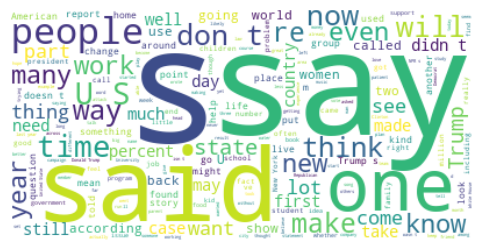

In [3]:
# Get all the text
text =  data.Article.to_list()
text = ' '.join(text)
wordcloud = WordCloud(background_color='white').generate(text)

# Plot Word Cloud
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('pics/npr_wordcloud', bbox_inches="tight");

In [4]:
no_words = len(text.split())
print(f'No Words {no_words},  Bible count: {no_words/no_bible_words}')

No Words 9266936,  Bible count: 11.478057523214522


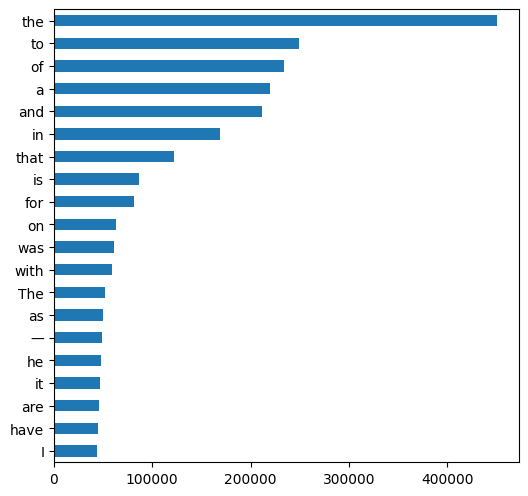

In [5]:
text = text.split()
text = pd.Series(text)
plt.figure(figsize=(6,6), dpi=100)
text.value_counts().head(20).plot.barh().invert_yaxis()
plt.savefig('pics/npr_word_freq');

## Preprocessing

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

In [6]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(data['Article'])

## Fitting the Data

### LDA

In [ ]:
LDA = LatentDirichletAllocation(n_components=7
                                , random_state=42
                                , n_jobs=-1
                                , verbose=1
                                , max_iter=100).fit(dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100


In [ ]:
print(len(cv.get_feature_names_out()), LDA.components_[0].shape)
keys = cv.get_feature_names_out()

In [ ]:
topics = []
for topic in LDA.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

### Word Frequency Word Cloud

In [ ]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(f"Topic_{n}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");
    n=n+1

### Word Frequency Barplot

In [ ]:
c=20
n=0
for topic in topics:

    df = pd.DataFrame(data=topic, index=[0])
    df = df.transpose()
    df.columns=['frequency']
    df = df.sort_values(by='frequency', ascending=False)


    plt.figure(figsize=(6,6), dpi=100)
    sns.barplot(y=df.index[:c], x=df.frequency[:c], color='blue')
    plt.title(f"Topic_{n}")
    plt.ylabel('Word')
    plt.savefig(f"pics/NPR_Topic_{n}", bbox_inches = "tight", dpi=300);

    n=n+1

In [ ]:
n=0
for topic in LDA.components_:
    print(f"Topic_{n}: {keys[topic.argsort()][-20:]}")
    n=n+1

In [ ]:
data['topic_raw'] = LDA.transform(dtm).argmax(axis=1)

In [ ]:
topics = {0: 'Finance'
          , 1: 'International News'
          , 2: 'National or Local News'
          , 3: 'Medical Research'
          , 4: 'Presidential Election'
          , 5: 'Cultural News'
          , 6: 'Education'
         }

In [ ]:
data['topic'] = data.topic_raw.apply(lambda x: topics[x])

In [ ]:
n=350
sample =  data.sample(2)
for topic, article in zip(sample.topic, sample.Article):
    print(topic)
    print(article[:n], end='\n\n')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
two_dims = pca.fit_transform(dtm.toarray())

In [ ]:
two_dims.shape, data.topic_raw.shape

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
sns.scatterplot(x=two_dims[:,0], y=two_dims[:,1], hue = data.topic_raw, alpha=0.3, palette='tab10')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
four_dims = pca.fit_transform(dtm.toarray())

In [ ]:
%matplotlib widget
plt.figure(figsize=(10,10), dpi=100)
axes = plt.axes(projection='3d')
axes.scatter(four_dims[:,0],four_dims[:,1],four_dims[:,2], s=-four_dims[:,3], c =data.topic_raw, alpha =0.3);

# Spotify

In [46]:
data = pd.read_csv('spotify_millsongdata.csv')
data.head()

artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \r\nA...  
1  Take it easy with me, please  \r\nTouch me gen...  
2  I'll never know why I had to go  \r\nWhy I had...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...

In [47]:
data.shape

(57650, 4)

In [48]:
text_data = data.text

Of course there is no topic to the artical or category for that matter thus we would need to set it ourselves 

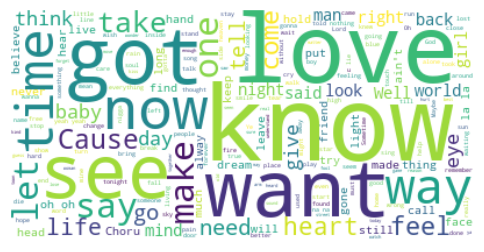

In [49]:
# Get all the text

text =  data.text.to_list()
text = ' '.join(text)
wordcloud = WordCloud(background_color='white').generate(text)

# Plot Word Cloud
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [258]:
no_words = len(text.split())
print(f'No Words {no_words},  Bible count: {no_words/no_bible_words}')

No Words 12653383,  Bible count: 15.672521957340026


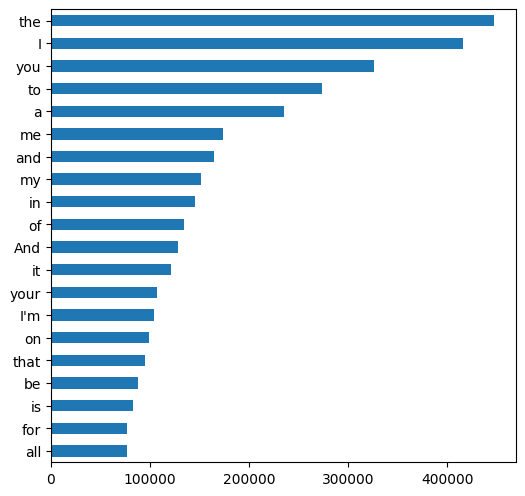

In [259]:
text = text.split()
text = pd.Series(text)

plt.figure(figsize=(6,6), dpi=100)
text = text.value_counts().head(20)
text.plot.barh().invert_yaxis()
plt.savefig('pics/spotify_word_freq');

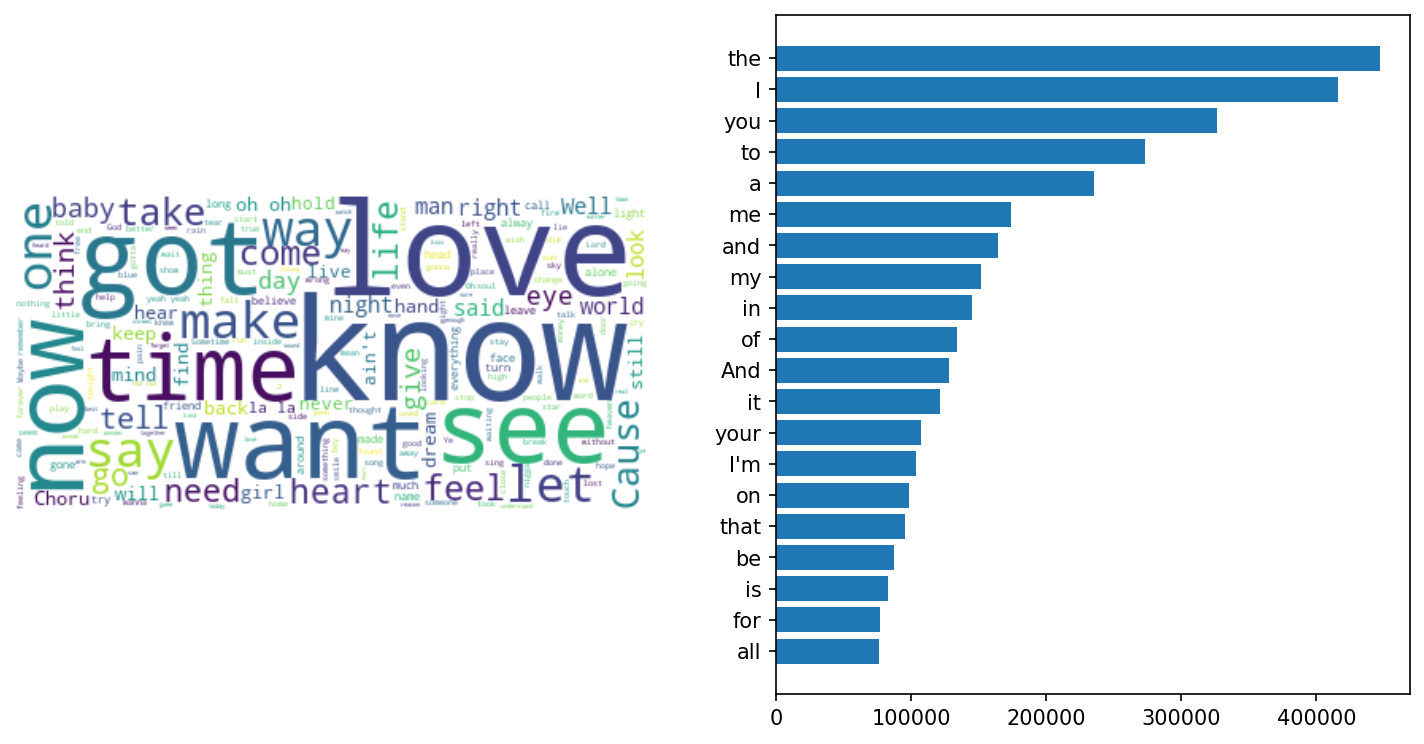

In [148]:
fig, axes= plt.subplots(ncols=2, figsize=(12,6), dpi=150)

axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis("off");

axes[1].barh(width=text.values, y=text.index)
axes[1].invert_yaxis()

plt.savefig(f"pics/spotify_word_count", bbox_inches = "tight", dpi=300)

## Preprocessing

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

In [260]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(data.text)

## Fitting the Data

### LDA

In [261]:
LDA = LatentDirichletAllocation(n_components=7
                                , random_state=42
                                , n_jobs=-1
                                , verbose=1
                                , max_iter=100).fit(dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

In [262]:
print(len(cv.get_feature_names_out()), LDA.components_[0].shape)
keys = cv.get_feature_names_out()

40546 (40546,)


In [263]:
topics = []
for topic in LDA.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

### Word Frequency Word Cloud

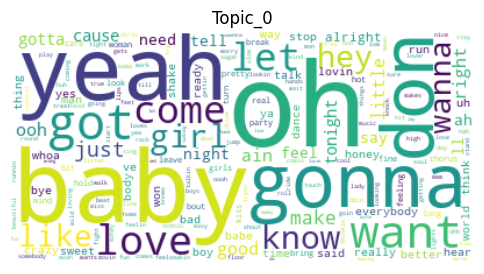

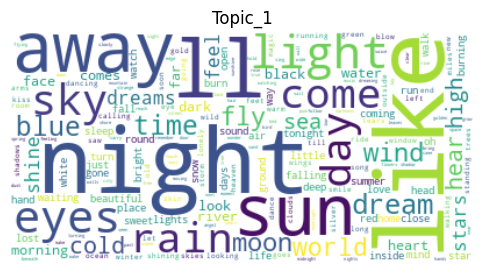

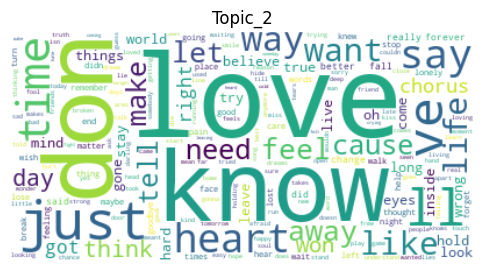

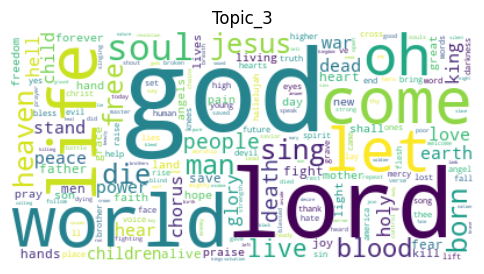

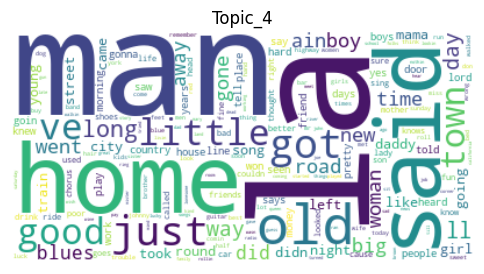

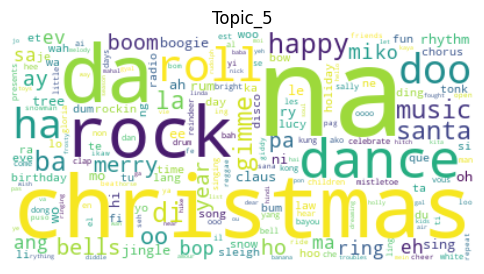

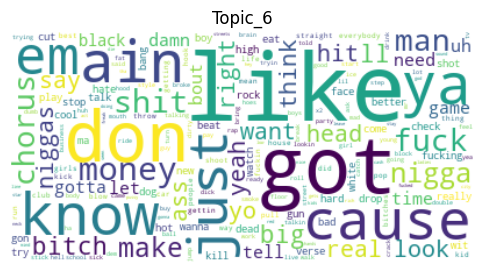

In [264]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(f'Topic_{n}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'pics/Spotify_Topic_{n}');
    n=n+1

### Word Frequency Barplot

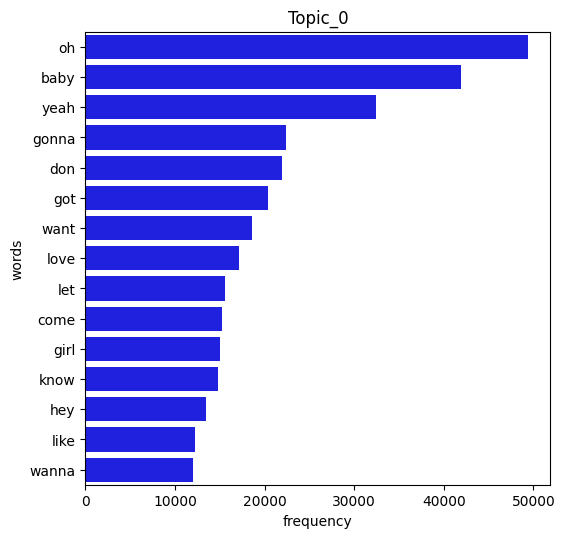

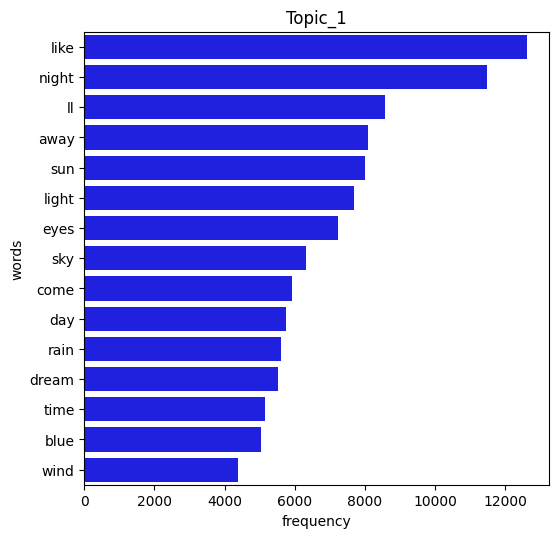

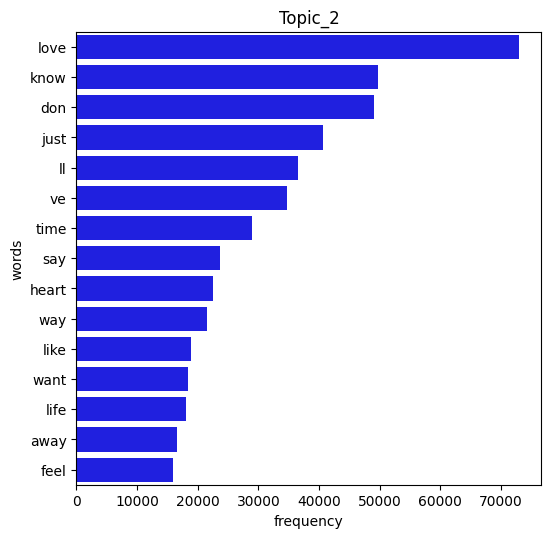

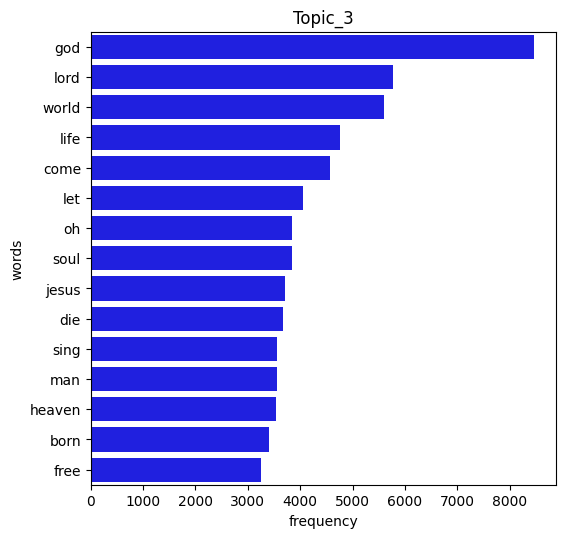

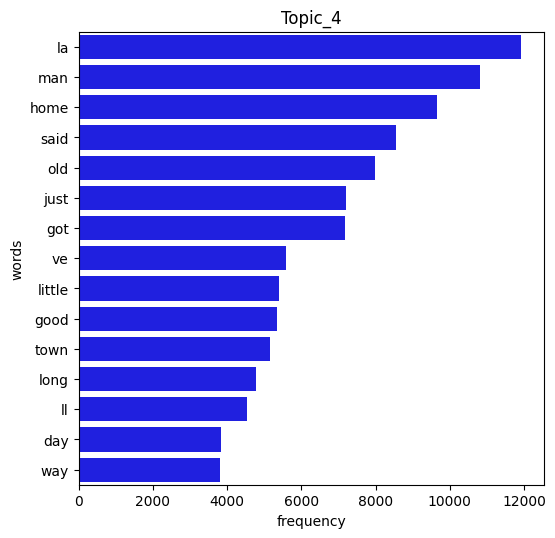

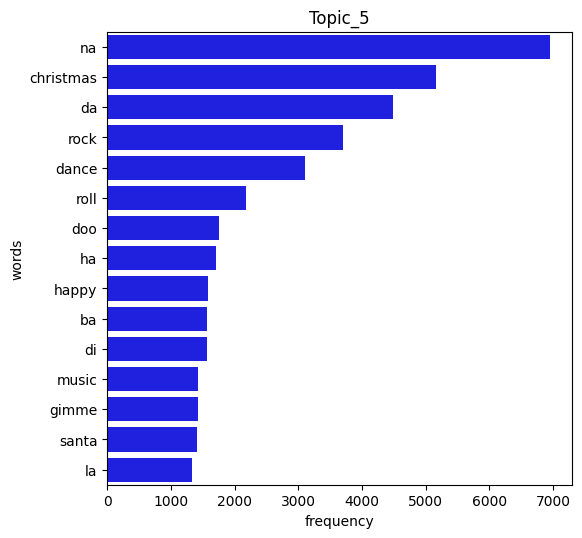

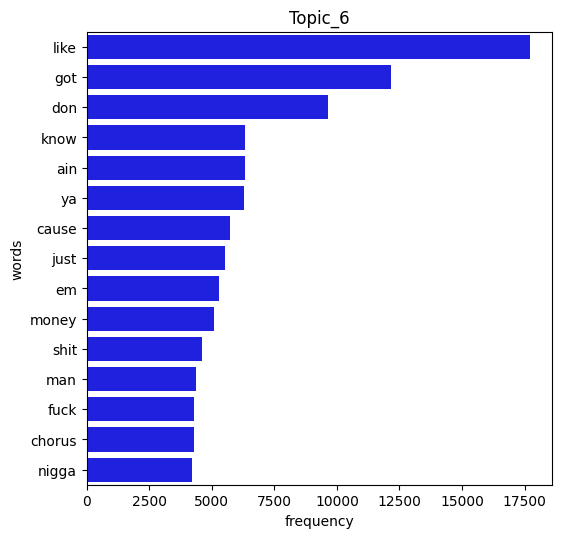

In [265]:
c = 15
words = cv.get_feature_names_out()
n=0
for frequency in LDA.components_:

    topic = pd.DataFrame(data= {'words': words, 'frequency':frequency})
    topic = topic.sort_values(by='frequency',ascending=False)
    topic.reset_index(drop=True)

    plt.figure(figsize=(6,6), dpi=100)
    sns.barplot(data=topic.head(c), y='words', x='frequency', color='blue')
    plt.title(f'Topic_{n}')
    
    plt.savefig(f'pics/Spotify_Topic_{n}_WordBar', bbox_inches = "tight", dpi=300);
    
    n=n+1

In [267]:
n = 0
for topic in LDA.components_:
    print(f"Topic_{n} : {keys[topic.argsort()][-15:]}")
    
    print('\n')
    n+=1

Topic_0 : ['wanna' 'like' 'hey' 'know' 'girl' 'come' 'let' 'love' 'want' 'got' 'don'
 'gonna' 'yeah' 'baby' 'oh']


Topic_1 : ['wind' 'blue' 'time' 'dream' 'rain' 'day' 'come' 'sky' 'eyes' 'light'
 'sun' 'away' 'll' 'night' 'like']


Topic_2 : ['feel' 'away' 'life' 'want' 'like' 'way' 'heart' 'say' 'time' 've' 'll'
 'just' 'don' 'know' 'love']


Topic_3 : ['free' 'born' 'heaven' 'man' 'sing' 'die' 'jesus' 'soul' 'oh' 'let'
 'come' 'life' 'world' 'lord' 'god']


Topic_4 : ['way' 'day' 'll' 'long' 'town' 'good' 'little' 've' 'got' 'just' 'old'
 'said' 'home' 'man' 'la']


Topic_5 : ['la' 'santa' 'gimme' 'music' 'di' 'ba' 'happy' 'ha' 'doo' 'roll' 'dance'
 'rock' 'da' 'christmas' 'na']


Topic_6 : ['nigga' 'chorus' 'fuck' 'man' 'shit' 'money' 'em' 'just' 'cause' 'ya'
 'ain' 'know' 'don' 'got' 'like']




In [268]:
data['topic_raw'] = LDA.transform(dtm).argmax(axis=1)

In [269]:
topics = {0: 'Subject of Courtship'
          , 1: 'Nature'
          , 2: 'Love'
          , 3: 'Divine'
          , 4: 'Locational'
          , 5: 'Holidays'
          , 6: 'Rap Music'
         }

In [270]:
data['topic'] = data.topic_raw.apply(lambda x: topics[x])
data.head()

artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  topic_raw  \
0  Look at her face, it's a wonderful face  \r\nA...          2   
1  Take it easy with me, please  \r\nTouch me gen...          0   
2  I'll never know why I had to go  \r\nWhy I had...          2   
3  Making somebody happy is a question of give an...          5   
4  Making somebody happy is a question of give an...          2   

                  topic  
0                  Love  
1  Subject of Courtship  
2                  Love  
3              Holidays  
4                  Love

In [201]:
n = 250
sample =  data.sample(2, random_state=1)
for topic, text, song, artist in zip(sample.topic, sample.text, sample.song, sample.artist):
    print(topic, end='\n\n')
    print(text[:n], end='\n\n')
    print(f'Song : {song} by {artist}', end='\n\n')
    print('='*50)

Locational

They're really rockin' Boston  
In Pittsburgh, P. A.  
Deep in the heart of Texas  
And 'round the Frisco Bay  
All over St. Louis  
And down in New Orleans  
All the cats want to dance with  
Sweet little sixteen  
  
Sweet little sixteen  

Song : Sweet Little Sixteen by Chuck Berry

Love

All my love  
Came to nothin' at all my love  
When I woke up to find  
You were no longer mine  
All my love  
Throw away after all this time  
Now there's no place for me  
In the future you see  
I don't understand you  
I've done all I c

Song : All My Love by Cliff Richard



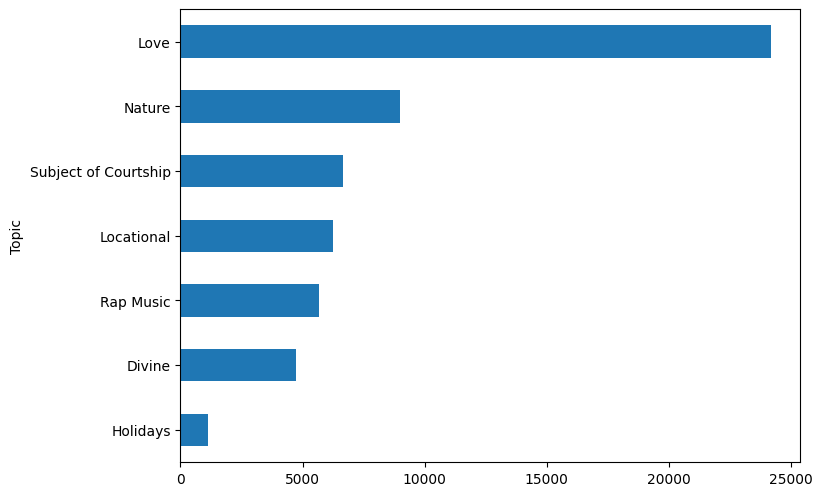

In [282]:
plt.figure(figsize=(8,6), dpi=100)
data.topic.value_counts().plot.barh().invert_yaxis()
plt.ylabel('Topic')
plt.savefig('pics/Spotify_Topic_Hierarchy', bbox_inches='tight');

### NMF

In [203]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = tfidf.fit_transform(data.text)

In [204]:
nmf_model = NMF(n_components=7,random_state=42, verbose=1, max_iter=1000)
nmf_model.fit(dtm)

C:\Users\alexandru.parvu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


violation: 1.0
violation: 0.6094456813255171
violation: 0.39255930163514685
violation: 0.2821797529379084
violation: 0.21209811571348533
violation: 0.15796156832025104
violation: 0.12170034455051063
violation: 0.09753055044773142
violation: 0.07985638936235832
violation: 0.06722333939146616
violation: 0.058030278681715224
violation: 0.04995095966941
violation: 0.04294987784260896
violation: 0.03772576926406213
violation: 0.033469913975141076
violation: 0.02981834347473299
violation: 0.02663103765822023
violation: 0.023843365647561766
violation: 0.021308360518594617
violation: 0.019042491611469682
violation: 0.017028475582817906
violation: 0.015201094235920504
violation: 0.013543089819308624
violation: 0.012004364455189794
violation: 0.01055404649411525
violation: 0.009064911966244099
violation: 0.008023855873486538
violation: 0.007132173178491571
violation: 0.006371472011159891
violation: 0.005721450160999916
violation: 0.0051642223099978846
violation: 0.004680525047437645
violation: 0

NMF(max_iter=1000, n_components=7, random_state=42, verbose=1)

In [205]:
print(tfidf.get_feature_names_out().shape, nmf_model.components_[0].shape)
keys = tfidf.get_feature_names_out()

(40546,) (40546,)


In [206]:
topics = []
for topic in nmf_model.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

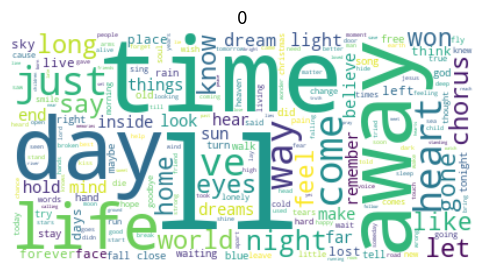

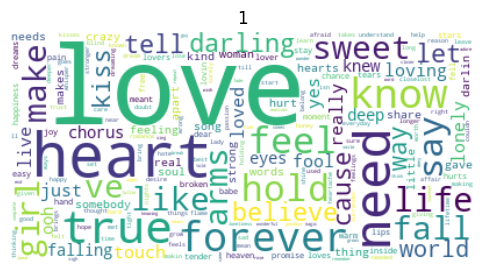

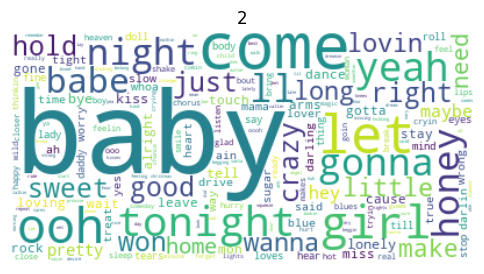

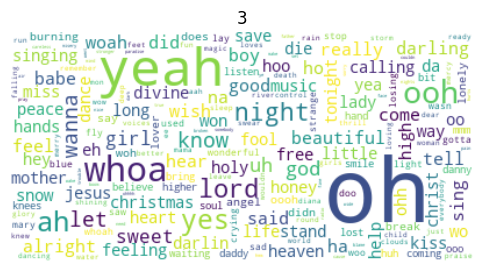

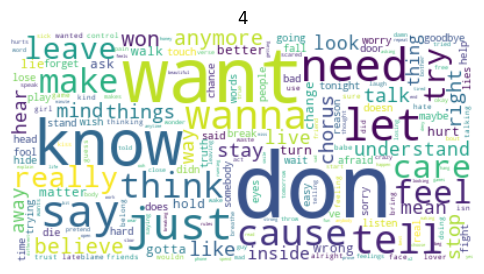

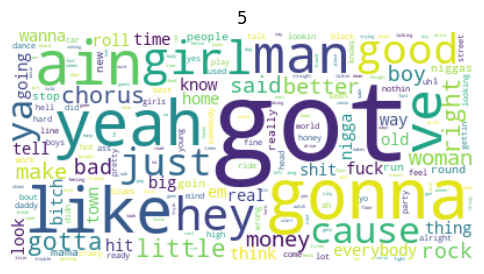

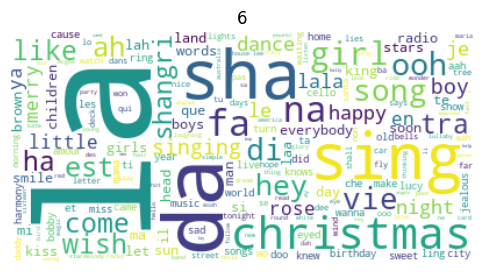

In [207]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(n)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");
    n=n+1

In [208]:
n = 0
for topic in LDA.components_:
    print(n)
    print(keys[topic.argsort()][-15:])
    print('\n')
    n+=1

0
['wanna' 'like' 'hey' 'know' 'girl' 'come' 'let' 'love' 'want' 'got' 'don'
 'gonna' 'yeah' 'baby' 'oh']


1
['wind' 'blue' 'time' 'dream' 'rain' 'day' 'come' 'sky' 'eyes' 'light'
 'sun' 'away' 'll' 'night' 'like']


2
['feel' 'away' 'life' 'want' 'like' 'way' 'heart' 'say' 'time' 've' 'll'
 'just' 'don' 'know' 'love']


3
['free' 'born' 'heaven' 'man' 'sing' 'die' 'jesus' 'soul' 'oh' 'let'
 'come' 'life' 'world' 'lord' 'god']


4
['way' 'day' 'll' 'long' 'town' 'good' 'little' 've' 'got' 'just' 'old'
 'said' 'home' 'man' 'la']


5
['la' 'santa' 'gimme' 'music' 'di' 'ba' 'happy' 'ha' 'doo' 'roll' 'dance'
 'rock' 'da' 'christmas' 'na']


6
['nigga' 'chorus' 'fuck' 'man' 'shit' 'money' 'em' 'just' 'cause' 'ya'
 'ain' 'know' 'don' 'got' 'like']




In [129]:
data['topic_raw'] = LDA.transform(dtm).argmax(axis=1)

In [130]:
topics = {0: 'Woman'
          , 1: 'Nature'
          , 2: 'Love'
          , 3: 'Religion'
          , 4: 'Home'
          , 5: 'Holiday'
          , 6: 'Gangster Stuff'
         }

In [131]:
data['topic'] = data.topic_raw.apply(lambda x: topics[x])
data.head()

artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  topic_raw  \
0  Look at her face, it's a wonderful face  \r\nA...          1   
1  Take it easy with me, please  \r\nTouch me gen...          1   
2  I'll never know why I had to go  \r\nWhy I had...          6   
3  Making somebody happy is a question of give an...          5   
4  Making somebody happy is a question of give an...          5   

            topic  
0          Nature  
1          Nature  
2  Gangster Stuff  
3         Holiday  
4         Holiday

In [137]:
sample =  data.sample(2)
for topic, text in zip(sample.topic, sample.text):
    print(topic)
    print(text, end='\n\n')

Gangster Stuff
Some kinda love, Margarita told Tom  
Between thought and expression lies a lifetime  
Situation arise, because of the weather  
And no kinds of love are better than others  
  
Some kinda love, Margarita told Tom  
Like a dirty French novel, the absurd court the vulgar  
And some kinds of love, the possibilities are endless  
And for me to miss one would seem to be groundless  
  
I heard what you said, Margarita heard Tom  
And of course you're a bore  
But you are not charmless in  
'Cause a bore is a straight line  
That finds wealth in division  
And some kinds of love are mistaken for vision  
  
Put jelly on your shoulder, let's do what you feel most  
That, from which you recoil, but which still makes your eyes moist  
Ooooh, put jelly on your shoulder, lies down upon the carpet  
Between thought and expression, let us now kiss the culprit  
Ooooh, I don't know, just what it's all about  
Oooh, put on your red pajamas and let's find out  
Lord rock it on, long wa

# Women's Clothing

In [249]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv').dropna()
data.drop('Unnamed: 0', inplace=True, axis=1)
data.head()

Clothing ID  Age                    Title  \
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   
5         1080   49  Not for the very petite   
6          858   39     Cagrcoal shimmer fun   

                                         Review Text  Rating  Recommended IND  \
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   
5  I love tracy reese dresses, but this one is no...       2                0   
6  I aded this in my basket at hte last mintue to...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses  
5                        4         General         Dresses    Dresses  
6                        1  General Petite            Tops      Knits

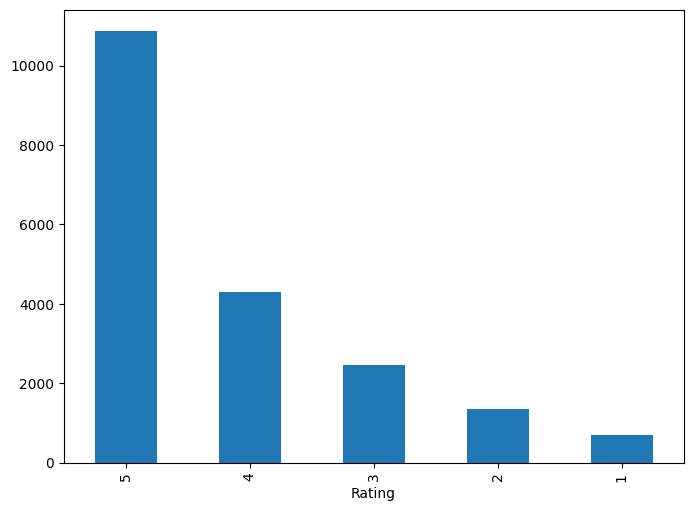

In [250]:
plt.figure(figsize=(8,6), dpi=100)
data.Rating.value_counts().plot.bar()
plt.xlabel('Rating')
plt.savefig('pics/womens_rating_distribution',  bbox_inches='tight');

In [251]:
data['positive_rating'] = data.Rating.apply(lambda x: x>=4)

Of course there is no topic to the artical or category for that matter thus we would need to set it ourselves 

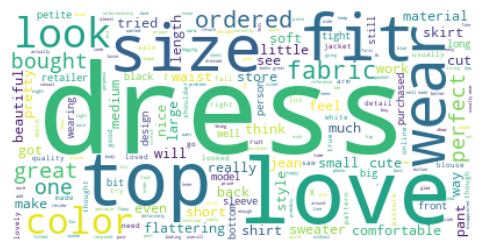

In [ ]:
# Get all the text
text_data = data['Review Text'].astype(str)
text = ' '.join(text_data)
wordcloud = WordCloud(background_color='white').generate(text)

# Plot Word Cloud
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.savefig('pics/womens_wordcloud', bbox_inches='tight');

In [253]:
no_words = len(text.split())
print(f'No Words {no_words},  Bible count: {no_words/no_bible_words}')

No Words 1221308,  Bible count: 1.5127161207935484


## Preprocessing

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

In [225]:
cv = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm = cv.fit_transform(data['Review Text'])

## Fitting the Data

### LDA

In [232]:
LDA = LatentDirichletAllocation(n_components=7
                                , random_state=42
                                , n_jobs=-1
                                , verbose=1
                                , max_iter=100).fit(dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

In [233]:
print(cv.get_feature_names_out().shape, LDA.components_.shape)
keys = cv.get_feature_names_out()

(3052,) (7, 3052)


In [234]:
topics = []
for topic in LDA.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

### Word Frequency Word Cloud

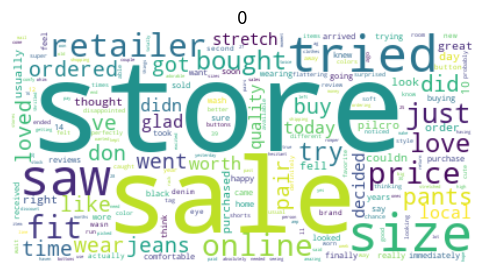

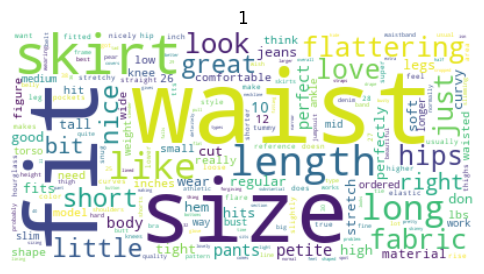

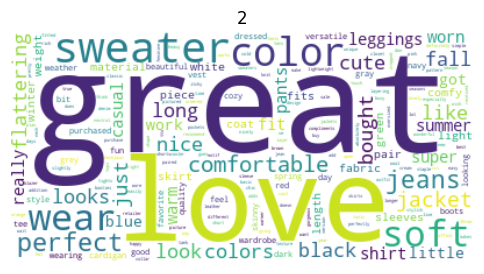

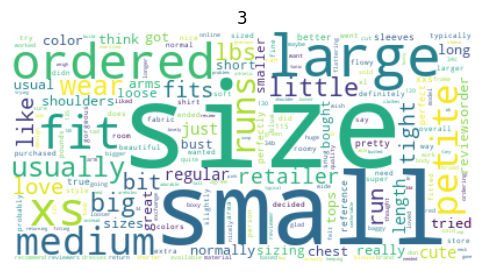

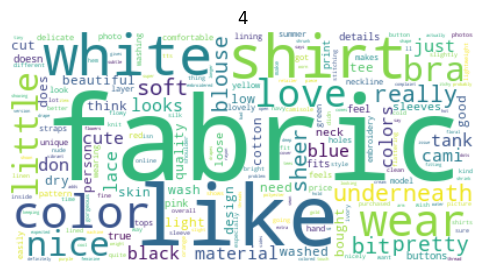

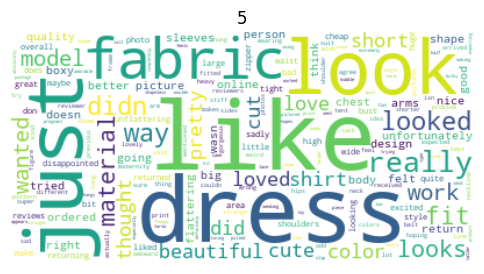

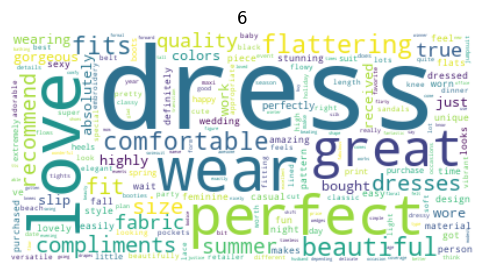

In [235]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(n)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");
    n=n+1

### Word Frequency Barplot

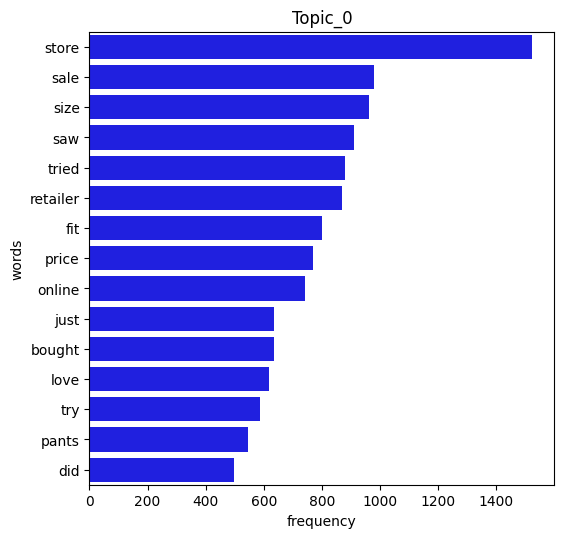

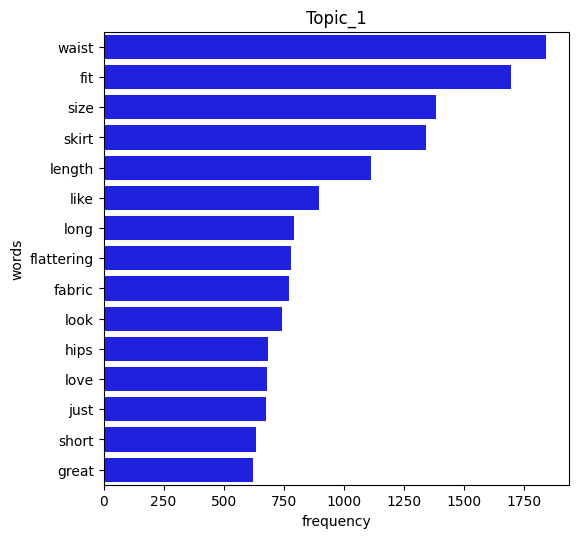

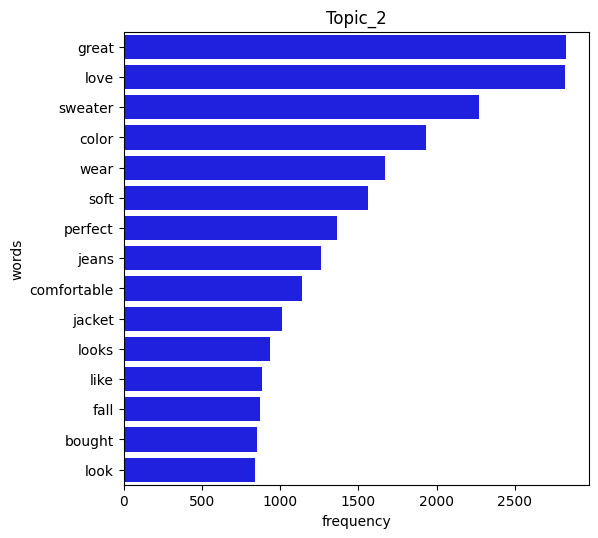

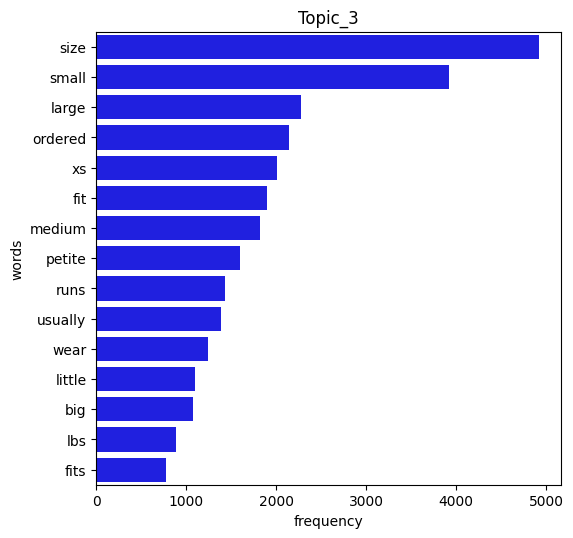

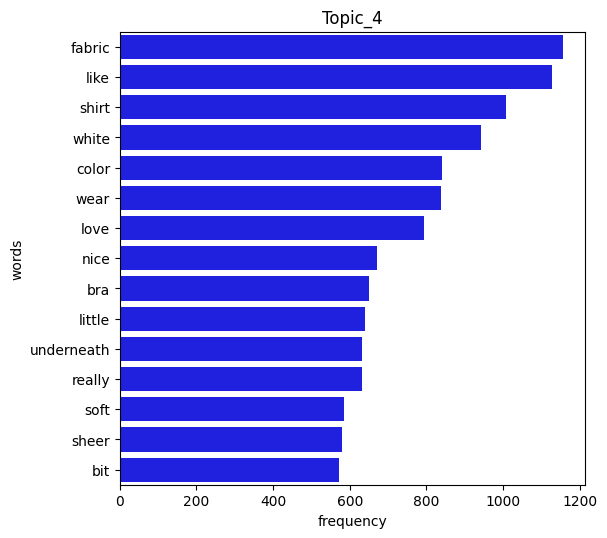

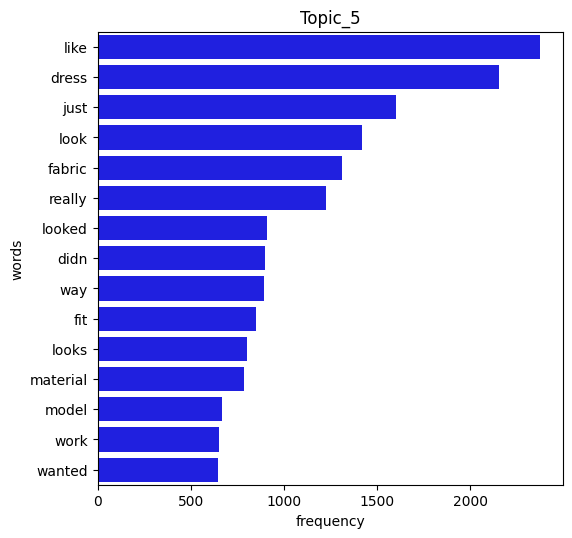

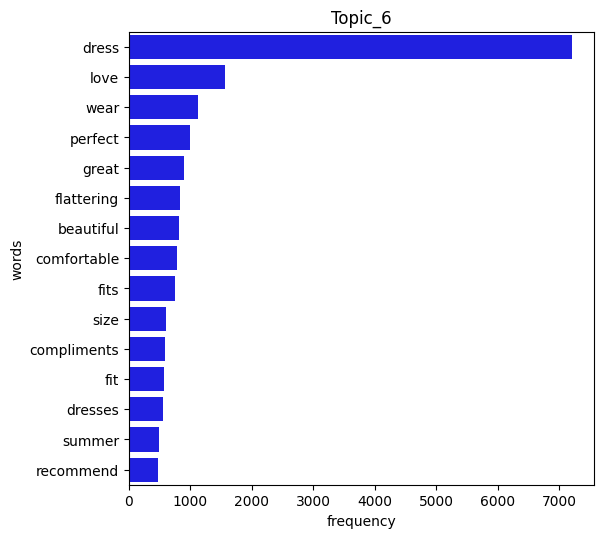

In [236]:
c = 15
words = cv.get_feature_names_out()
n=0
for frequency in LDA.components_:

    topic = pd.DataFrame(data= {'words': words, 'frequency':frequency})
    topic = topic.sort_values(by='frequency',ascending=False)
    topic.reset_index(drop=True)

    plt.figure(figsize=(6,6), dpi=100)
    sns.barplot(data=topic.head(c), y='words', x='frequency', color='blue')
    plt.title(f'Topic_{n}')
    
    plt.savefig(f'pics/Womens_Topic_{n}_WordBar', bbox_inches = "tight", dpi=300);
    
    n=n+1

In [244]:
n = 0
for topic in LDA.components_:
    value = keys[topic.argsort()][-20:] 
    value = list(value)
    print(f'Topic_{n} : {value}')
    print('\n')
    n+=1

Topic_0 : ['don', 'ordered', 'went', 'got', 'jeans', 'did', 'pants', 'try', 'love', 'bought', 'just', 'online', 'price', 'fit', 'retailer', 'tried', 'saw', 'size', 'sale', 'store']


Topic_1 : ['petite', 'bit', 'right', 'nice', 'little', 'great', 'short', 'just', 'love', 'hips', 'look', 'fabric', 'flattering', 'long', 'like', 'length', 'skirt', 'size', 'fit', 'waist']


Topic_2 : ['long', 'colors', 'cute', 'nice', 'black', 'look', 'bought', 'fall', 'like', 'looks', 'jacket', 'comfortable', 'jeans', 'perfect', 'soft', 'wear', 'color', 'sweater', 'love', 'great']


Topic_3 : ['retailer', 'run', 'like', 'love', 'bit', 'fits', 'lbs', 'big', 'little', 'wear', 'usually', 'runs', 'petite', 'medium', 'fit', 'xs', 'ordered', 'large', 'small', 'size']


Topic_4 : ['looks', 'colors', 'material', 'blouse', 'pretty', 'bit', 'sheer', 'soft', 'really', 'underneath', 'little', 'bra', 'nice', 'love', 'wear', 'color', 'white', 'shirt', 'like', 'fabric']


Topic_5 : ['cut', 'cute', 'loved', 'beautiful', 

In [245]:
topics = {0: 'Sale'
          , 1: 'Size'
          , 2: 'Confort'
          , 3: 'Small Sizes'
          , 4: 'Material and Color'
          , 5: 'Appearance'
          , 6: 'Dresses'
         }

In [246]:
data['topic_raw'] = LDA.transform(dtm).argmax(axis=1)
# data[['Review Text', 'topic_raw']]
data

Clothing ID  Age                                              Title  \
2             1077   60                            Some major design flaws   
3             1049   50                                   My favorite buy!   
4              847   47                                   Flattering shirt   
5             1080   49                            Not for the very petite   
6              858   39                               Cagrcoal shimmer fun   
...            ...  ...                                                ...   
23481         1104   34                     Great dress for many occasions   
23482          862   48                         Wish it was made of cotton   
23483         1104   31                              Cute, but see through   
23484         1084   28  Very cute dress, perfect for summer parties an...   
23485         1104   52                    Please make more like this one!   

                                             Review Text  Rating  \
2      I had such high hopes for this dress and reall...       3   
3      I love, love, love this jumpsuit. it's fun, fl...       5   
4      This shirt is very flattering to all due to th...       5   
5      I love tracy reese dresses, but this one is no...       2   
6      I aded this in my basket at hte last mintue to...       5   
...                                                  ...     ...   
23481  I was very happy to snag this dress at such a ...       5   
23482  It reminds me of maternity clothes. soft, stre...       3   
23483  This fit well, but the top was very see throug...       3   
23484  I bought this dress for a wedding i have this ...       3   
23485  This dress in a lovely platinum is feminine an...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
2                    0                        0         General   
3                    1                        0  General Petite   
4                    1                        6         General   
5                    0                        4         General   
6                    1                        1  General Petite   
...                ...                      ...             ...   
23481                1                        0  General Petite   
23482                1                        0  General Petite   
23483                0                        1  General Petite   
23484                1                        2         General   
23485                1                       22  General Petite   

      Department Name Class Name  topic_raw  
2             Dresses    Dresses          3  
3             Bottoms      Pants          6  
4                Tops    Blouses          2  
5             Dresses    Dresses          1  
6                Tops      Knits          3  
...               ...        ...        ...  
23481         Dresses    Dresses          6  
23482            Tops      Knits          5  
23483         Dresses    Dresses          0  
23484         Dresses    Dresses          5  
23485         Dresses    Dresses          6  

[19662 rows x 11 columns]

In [247]:
data['topic'] = data.topic_raw.apply(lambda x: topics[x])
data[['Review Text', 'topic_raw', 'topic']]

Review Text  topic_raw  \
2      I had such high hopes for this dress and reall...          3   
3      I love, love, love this jumpsuit. it's fun, fl...          6   
4      This shirt is very flattering to all due to th...          2   
5      I love tracy reese dresses, but this one is no...          1   
6      I aded this in my basket at hte last mintue to...          3   
...                                                  ...        ...   
23481  I was very happy to snag this dress at such a ...          6   
23482  It reminds me of maternity clothes. soft, stre...          5   
23483  This fit well, but the top was very see throug...          0   
23484  I bought this dress for a wedding i have this ...          5   
23485  This dress in a lovely platinum is feminine an...          6   

             topic  
2      Small Sizes  
3          Dresses  
4          Confort  
5             Size  
6      Small Sizes  
...            ...  
23481      Dresses  
23482   Appearance  
23483         Sale  
23484   Appearance  
23485      Dresses  

[19662 rows x 3 columns]

In [250]:
sample =  data.sample(2)
for topic, text in zip(sample['topic'], sample['Review Text']):
    print(topic, end='\n\n')
    print(text, end='\n\n')
    print("="*50)

Material and Color

I'm not usually a fan of simple crewneck sweaters but this one has some nice added details that make it a keeper. the dark red oxblood color is really nice (it manages to be a red sweater without feeling overly holiday), the detailing at shoulder/chest is interesting yet subtle enough to not be distracting and doesn't feel bulky at all, the dropped shoulder seams are done correctly and without the body becoming boxy. it does feel like it might run a tad bit large, but only very slightly, not eno

Appearance

I love natural colors and nature themes but this top was a disappointment. i ordered both the small and the xs because retailer can run very large. the small was too big and the xs did not hang correctly, the arms hit at a weird spot and the neckline wouldn't sit right. overall the fit was boxy and unflattering. the fabric is pretty but the style is well....boring. there was just no wow factor for me. i think the fabric deserved a much better design. imho i thin

### LDA by positive and negative retaing

#### Positive

In [212]:
positive = data[data.positive_rating].copy()
positive = positive.reset_index(drop=True)
positive

Clothing ID  Age                                 Title  \
0             1049   50                      My favorite buy!   
1              847   47                      Flattering shirt   
2              858   39                  Cagrcoal shimmer fun   
3              858   39  Shimmer, surprisingly goes with lots   
4             1077   24                            Flattering   
...            ...  ...                                   ...   
15142          522   27                               Cheeky!   
15143         1094   39                            Entrancing   
15144         1005   42                     What a fun piece!   
15145         1104   34        Great dress for many occasions   
15146         1104   52       Please make more like this one!   

                                             Review Text  Rating  \
0      I love, love, love this jumpsuit. it's fun, fl...       5   
1      This shirt is very flattering to all due to th...       5   
2      I aded this in my basket at hte last mintue to...       5   
3      I ordered this in carbon for store pick up, an...       4   
4      I love this dress. i usually get an xs but it ...       5   
...                                                  ...     ...   
15142  These bottoms are very cute but defiantly chee...       4   
15143  I'm so impressed with the beautiful color comb...       4   
15144  So i wasn't sure about ordering this skirt bec...       5   
15145  I was very happy to snag this dress at such a ...       5   
15146  This dress in a lovely platinum is feminine an...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
0                    1                        0  General Petite   
1                    1                        6         General   
2                    1                        1  General Petite   
3                    1                        4  General Petite   
4                    1                        0         General   
...                ...                      ...             ...   
15142                1                        0       Initmates   
15143                1                        5  General Petite   
15144                1                        0  General Petite   
15145                1                        0  General Petite   
15146                1                       22  General Petite   

      Department Name Class Name  positive_rating  
0             Bottoms      Pants             True  
1                Tops    Blouses             True  
2                Tops      Knits             True  
3                Tops      Knits             True  
4             Dresses    Dresses             True  
...               ...        ...              ...  
15142        Intimate       Swim             True  
15143         Dresses    Dresses             True  
15144         Bottoms     Skirts             True  
15145         Dresses    Dresses             True  
15146         Dresses    Dresses             True  

[15147 rows x 11 columns]

In [213]:
cv = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm = cv.fit_transform(positive['Review Text'])

##### LDA

In [214]:
LDA = LatentDirichletAllocation(n_components=4
                                , random_state=42
                                , n_jobs=-1
                                , verbose=1
                                , max_iter=100).fit(dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

In [215]:
print(cv.get_feature_names_out().shape, LDA.components_.shape)
keys = cv.get_feature_names_out()

(2607,) (4, 2607)


In [216]:
topics = []
for topic in LDA.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

##### Word Frequency Word Cloud

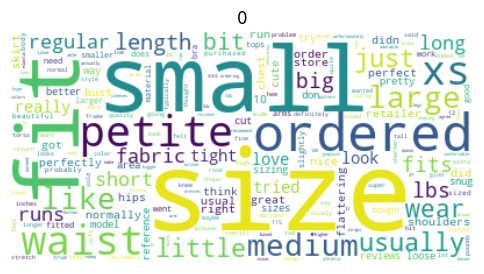

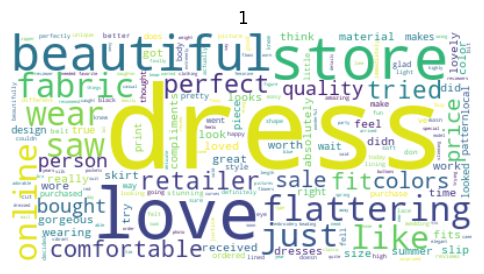

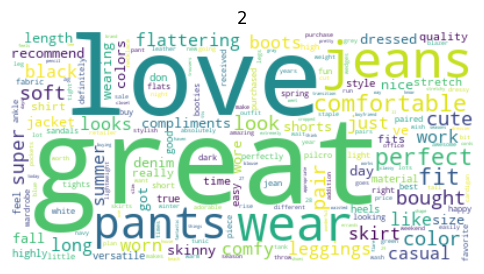

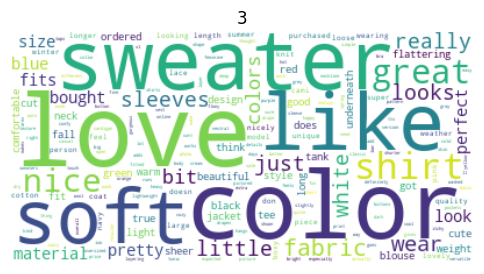

In [217]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(n)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");
    n=n+1

##### Word Frequency Barplot

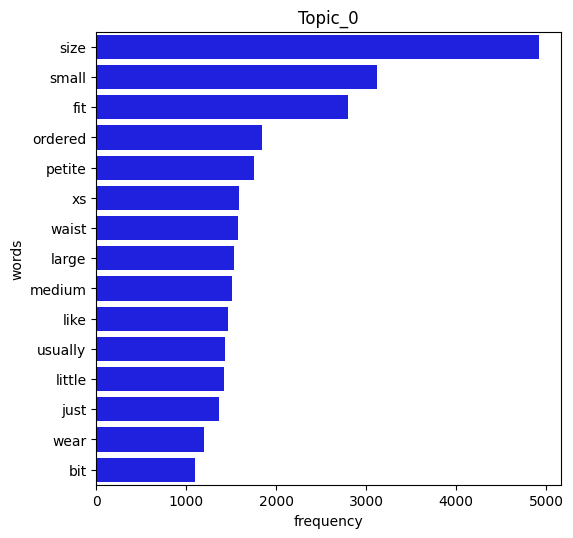

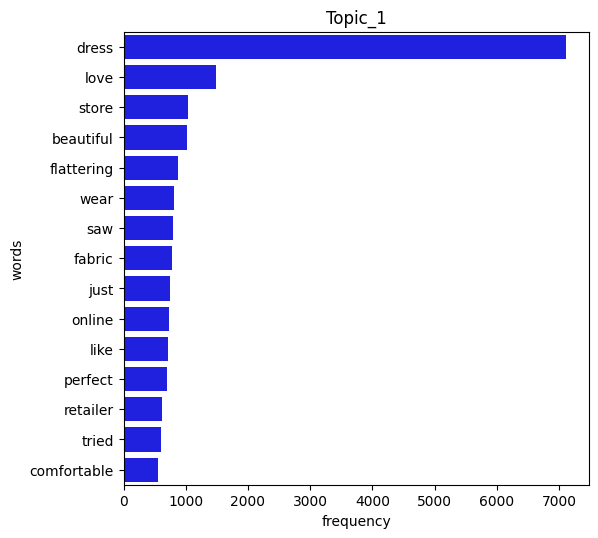

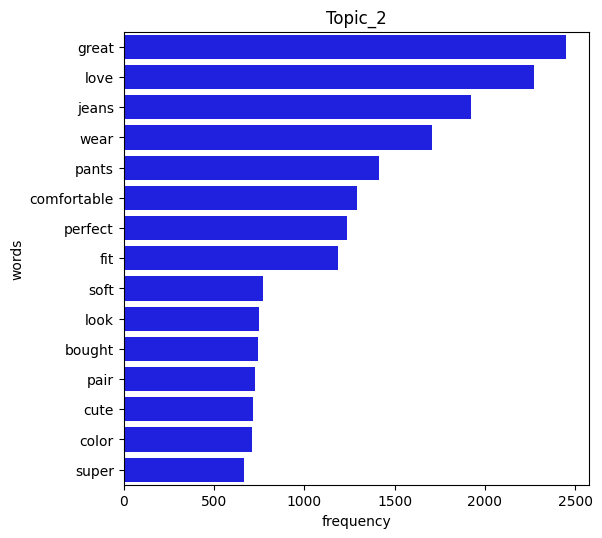

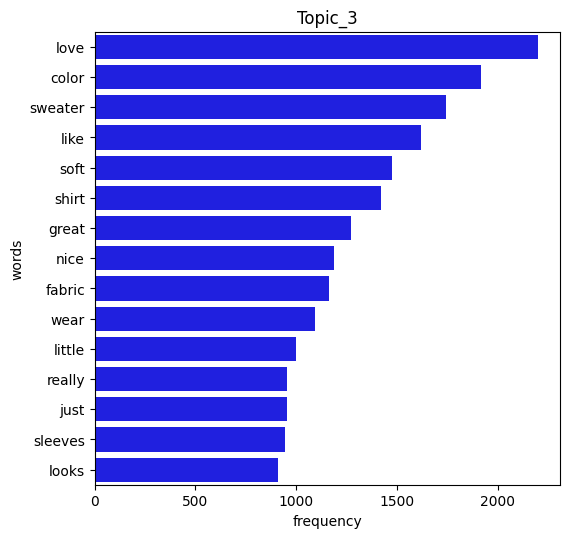

In [218]:
c = 15
words = cv.get_feature_names_out()
n=0
for frequency in LDA.components_:

    topic = pd.DataFrame(data= {'words': words, 'frequency':frequency})
    topic = topic.sort_values(by='frequency',ascending=False)
    topic.reset_index(drop=True)

    plt.figure(figsize=(6,6), dpi=100)
    sns.barplot(data=topic.head(c), y='words', x='frequency', color='blue')
    plt.title(f'Topic_{n}')
    
    plt.savefig(f'pics/Womens_Topic_{n}_WordBar', bbox_inches = "tight", dpi=300);
    
    n=n+1

In [219]:
n = 0
for topic in LDA.components_:
    value = keys[topic.argsort()][-20:] 
    value = list(value)
    print(f'Topic_{n} : {value}')
    print('\n')
    n+=1

Topic_0 : ['regular', 'big', 'fits', 'lbs', 'length', 'bit', 'wear', 'just', 'little', 'usually', 'like', 'medium', 'large', 'waist', 'xs', 'petite', 'ordered', 'fit', 'small', 'size']


Topic_1 : ['quality', 'colors', 'price', 'sale', 'fit', 'comfortable', 'tried', 'retailer', 'perfect', 'like', 'online', 'just', 'fabric', 'saw', 'wear', 'flattering', 'beautiful', 'store', 'love', 'dress']


Topic_2 : ['casual', 'black', 'worn', 'leggings', 'like', 'super', 'color', 'cute', 'pair', 'bought', 'look', 'soft', 'fit', 'perfect', 'comfortable', 'pants', 'wear', 'jeans', 'love', 'great']


Topic_3 : ['pretty', 'bought', 'colors', 'bit', 'white', 'looks', 'sleeves', 'just', 'really', 'little', 'wear', 'fabric', 'nice', 'great', 'shirt', 'soft', 'like', 'sweater', 'color', 'love']




In [220]:
topics = {0: 'Small Sizes Fitting'
          , 1: 'Price to Quality Ratio'
          , 2: 'Casual Clothing'
          , 3: 'Appearance'
         }

In [221]:
positive['topic_raw'] = LDA.transform(dtm).argmax(axis=1)
positive

Clothing ID  Age                                 Title  \
0             1049   50                      My favorite buy!   
1              847   47                      Flattering shirt   
2              858   39                  Cagrcoal shimmer fun   
3              858   39  Shimmer, surprisingly goes with lots   
4             1077   24                            Flattering   
...            ...  ...                                   ...   
15142          522   27                               Cheeky!   
15143         1094   39                            Entrancing   
15144         1005   42                     What a fun piece!   
15145         1104   34        Great dress for many occasions   
15146         1104   52       Please make more like this one!   

                                             Review Text  Rating  \
0      I love, love, love this jumpsuit. it's fun, fl...       5   
1      This shirt is very flattering to all due to th...       5   
2      I aded this in my basket at hte last mintue to...       5   
3      I ordered this in carbon for store pick up, an...       4   
4      I love this dress. i usually get an xs but it ...       5   
...                                                  ...     ...   
15142  These bottoms are very cute but defiantly chee...       4   
15143  I'm so impressed with the beautiful color comb...       4   
15144  So i wasn't sure about ordering this skirt bec...       5   
15145  I was very happy to snag this dress at such a ...       5   
15146  This dress in a lovely platinum is feminine an...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
0                    1                        0  General Petite   
1                    1                        6         General   
2                    1                        1  General Petite   
3                    1                        4  General Petite   
4                    1                        0         General   
...                ...                      ...             ...   
15142                1                        0       Initmates   
15143                1                        5  General Petite   
15144                1                        0  General Petite   
15145                1                        0  General Petite   
15146                1                       22  General Petite   

      Department Name Class Name  positive_rating  topic_raw  
0             Bottoms      Pants             True          2  
1                Tops    Blouses             True          2  
2                Tops      Knits             True          0  
3                Tops      Knits             True          0  
4             Dresses    Dresses             True          0  
...               ...        ...              ...        ...  
15142        Intimate       Swim             True          0  
15143         Dresses    Dresses             True          0  
15144         Bottoms     Skirts             True          1  
15145         Dresses    Dresses             True          1  
15146         Dresses    Dresses             True          2  

[15147 rows x 12 columns]

In [222]:
positive['topic'] = positive.topic_raw.apply(lambda x: topics[x])
positive[['Review Text', 'topic_raw', 'topic']]

Review Text  topic_raw  \
0      I love, love, love this jumpsuit. it's fun, fl...          2   
1      This shirt is very flattering to all due to th...          2   
2      I aded this in my basket at hte last mintue to...          0   
3      I ordered this in carbon for store pick up, an...          0   
4      I love this dress. i usually get an xs but it ...          0   
...                                                  ...        ...   
15142  These bottoms are very cute but defiantly chee...          0   
15143  I'm so impressed with the beautiful color comb...          0   
15144  So i wasn't sure about ordering this skirt bec...          1   
15145  I was very happy to snag this dress at such a ...          1   
15146  This dress in a lovely platinum is feminine an...          2   

                        topic  
0             Casual Clothing  
1             Casual Clothing  
2         Small Sizes Fitting  
3         Small Sizes Fitting  
4         Small Sizes Fitting  
...                       ...  
15142     Small Sizes Fitting  
15143     Small Sizes Fitting  
15144  Price to Quality Ratio  
15145  Price to Quality Ratio  
15146         Casual Clothing  

[15147 rows x 3 columns]

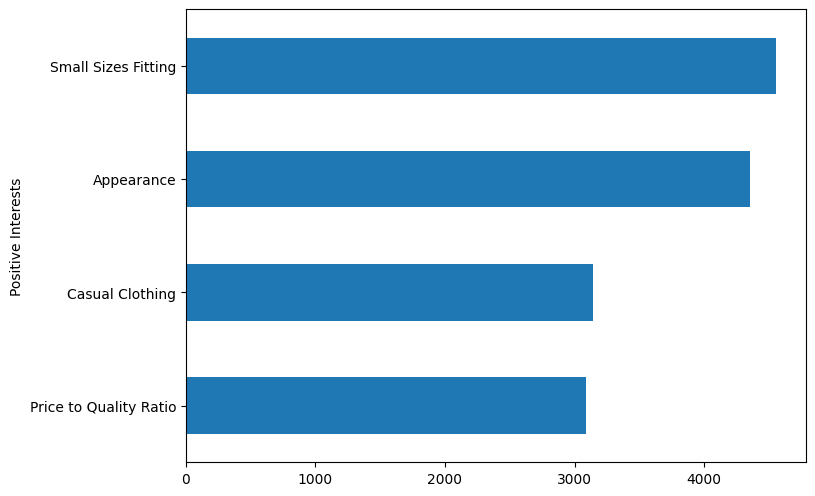

In [285]:
plt.figure(figsize=(8,6), dpi=100)
positive.topic.value_counts().plot.barh().invert_yaxis()
plt.ylabel('Positive Interests')
plt.savefig('pics/womens_positive_interest', bbox_inches='tight', dpi=450)

In [224]:
sample =  positive.sample(2)
for topic, text in zip(sample['topic'], sample['Review Text']):
    print(topic, end='\n\n')
    print(text, end='\n\n')
    print("="*50)

Casual Clothing

Love it! i am 125# and usually a size 2-4 or 26-27 in bottoms. typically size up for holding horses. based on other reviews, i ordered this in a 2. it stretched just a bit after wearing all day, so i'm glad i didn't get my normal 4. the fit is great, quality is great. it dresses up for a casual office day, wearing well with boots and tights, and i imagine pairing with tshirt and flip flops over the summer. i unique piece that quickly became a favorite.

Casual Clothing

This is an awesome t'shirt and i'm so glad it finally went on sale. i had been eying it for a while: it's true to size, can be dressed up with nice slacks or dressed down with boyfriend jeans. washes great and looks different from other shirts -- the ruffles on the bottom really make a difference. gotten lots of compliments.



#### Negative

In [225]:
negative = data[data.positive_rating==False].copy()
negative = negative.reset_index(drop=True)
negative

Clothing ID  Age                                              Title  \
0            1077   60                            Some major design flaws   
1            1080   49                            Not for the very petite   
2            1077   53       Dress looks like it's made of cheap material   
3            1077   50                Pretty party dress with some issues   
4            1065   34  You need to be at least average height, or taller   
...           ...  ...                                                ...   
4510         1104   41                                         Cute dress   
4511         1104   32                                       Unflattering   
4512          862   48                         Wish it was made of cotton   
4513         1104   31                              Cute, but see through   
4514         1084   28  Very cute dress, perfect for summer parties an...   

                                            Review Text  Rating  \
0     I had such high hopes for this dress and reall...       3   
1     I love tracy reese dresses, but this one is no...       2   
2     Dress runs small esp where the zipper area run...       3   
3     This is a nice choice for holiday gatherings. ...       3   
4     Material and color is nice.  the leg opening i...       3   
...                                                 ...     ...   
4510  Cute dress but not for me.  the waist is too h...       3   
4511  I was surprised at the positive reviews for th...       1   
4512  It reminds me of maternity clothes. soft, stre...       3   
4513  This fit well, but the top was very see throug...       3   
4514  I bought this dress for a wedding i have this ...       3   

      Recommended IND  Positive Feedback Count   Division Name  \
0                   0                        0         General   
1                   0                        4         General   
2                   0                       14         General   
3                   1                        1         General   
4                   1                        2         General   
...               ...                      ...             ...   
4510                1                        0  General Petite   
4511                0                        0  General Petite   
4512                1                        0  General Petite   
4513                0                        1  General Petite   
4514                1                        2         General   

     Department Name Class Name  positive_rating  
0            Dresses    Dresses            False  
1            Dresses    Dresses            False  
2            Dresses    Dresses            False  
3            Dresses    Dresses            False  
4            Bottoms      Pants            False  
...              ...        ...              ...  
4510         Dresses    Dresses            False  
4511         Dresses    Dresses            False  
4512            Tops      Knits            False  
4513         Dresses    Dresses            False  
4514         Dresses    Dresses            False  

[4515 rows x 11 columns]

In [226]:
cv = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm = cv.fit_transform(negative['Review Text'])

##### LDA

In [227]:
LDA = LatentDirichletAllocation(n_components=4
                                , random_state=42
                                , n_jobs=-1
                                , verbose=1
                                , max_iter=100).fit(dtm)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

In [228]:
print(cv.get_feature_names_out().shape, LDA.components_.shape)
keys = cv.get_feature_names_out()

(1399,) (4, 1399)


In [229]:
topics = []
for topic in LDA.components_:
    d  = {}
    for key, value in zip(keys, topic):
        d[key] = value
    topics.append(d)

##### Word Frequency Word Cloud

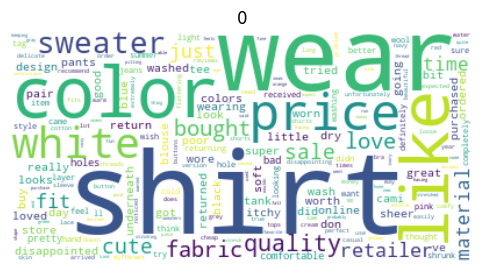

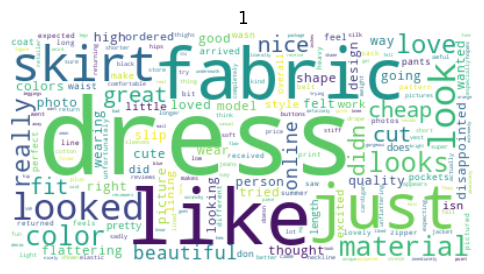

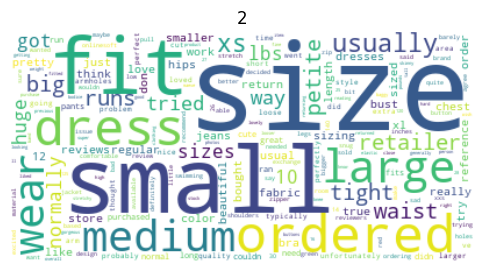

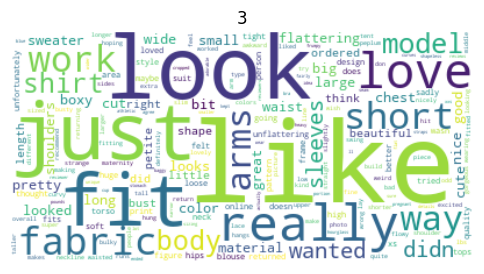

In [230]:
n=0
for topic in topics:
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(topic)
    plt.figure(figsize=(6,6), dpi=100)
    plt.title(n)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");
    n=n+1

##### Word Frequency Barplot

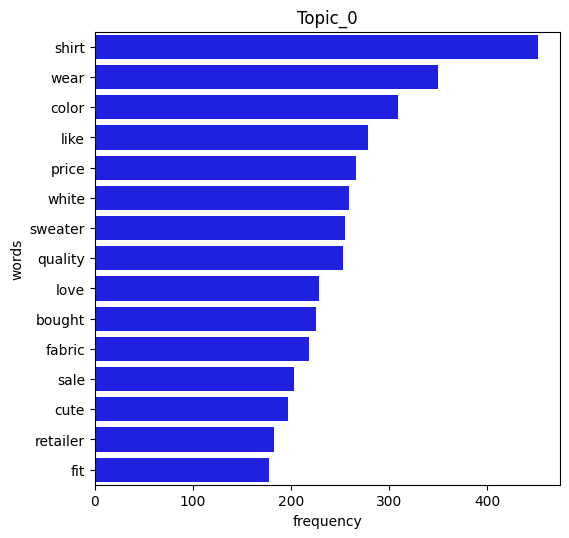

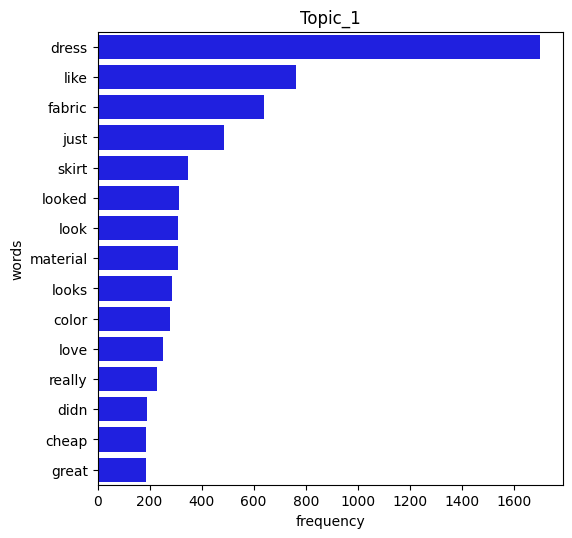

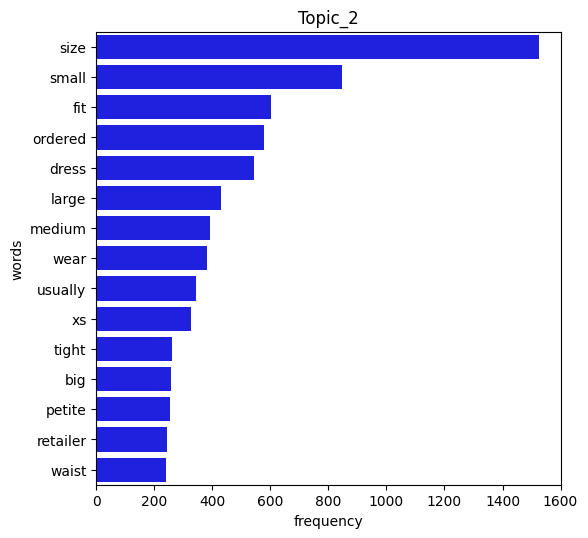

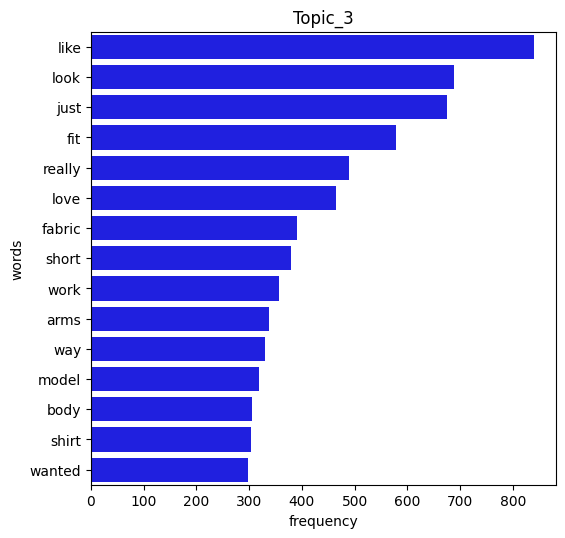

In [231]:
c = 15
words = cv.get_feature_names_out()
n=0
for frequency in LDA.components_:

    topic = pd.DataFrame(data= {'words': words, 'frequency':frequency})
    topic = topic.sort_values(by='frequency',ascending=False)
    topic.reset_index(drop=True)

    plt.figure(figsize=(6,6), dpi=100)
    sns.barplot(data=topic.head(c), y='words', x='frequency', color='blue')
    plt.title(f'Topic_{n}')
    
    plt.savefig(f'pics/Womens_Topic_{n}_WordBar', bbox_inches = "tight", dpi=300);
    
    n=n+1

In [232]:
n = 0
for topic in LDA.components_:
    value = keys[topic.argsort()][-20:] 
    value = list(value)
    print(f'Topic_{n} : {value}')
    print('\n')
    n+=1

Topic_0 : ['wash', 'disappointed', 'material', 'just', 'time', 'fit', 'retailer', 'cute', 'sale', 'fabric', 'bought', 'love', 'quality', 'sweater', 'white', 'price', 'like', 'color', 'wear', 'shirt']


Topic_1 : ['online', 'beautiful', 'fit', 'nice', 'cut', 'great', 'cheap', 'didn', 'really', 'love', 'color', 'looks', 'material', 'look', 'looked', 'skirt', 'just', 'fabric', 'like', 'dress']


Topic_2 : ['sizes', 'lbs', 'way', 'tried', 'runs', 'waist', 'retailer', 'petite', 'big', 'tight', 'xs', 'usually', 'wear', 'medium', 'large', 'dress', 'ordered', 'fit', 'small', 'size']


Topic_3 : ['sweater', 'material', 'flattering', 'didn', 'sleeves', 'wanted', 'shirt', 'body', 'model', 'way', 'arms', 'work', 'short', 'fabric', 'love', 'really', 'fit', 'just', 'look', 'like']




In [233]:
topics = {0: "Top Color and Material"
          , 1: "Dress Cheap Fabric"
          , 2: "Larger Small Sizes"
          , 3: "Top Fit and Look"
         }

In [234]:
negative['topic_raw'] = LDA.transform(dtm).argmax(axis=1)
negative

Clothing ID  Age                                              Title  \
0            1077   60                            Some major design flaws   
1            1080   49                            Not for the very petite   
2            1077   53       Dress looks like it's made of cheap material   
3            1077   50                Pretty party dress with some issues   
4            1065   34  You need to be at least average height, or taller   
...           ...  ...                                                ...   
4510         1104   41                                         Cute dress   
4511         1104   32                                       Unflattering   
4512          862   48                         Wish it was made of cotton   
4513         1104   31                              Cute, but see through   
4514         1084   28  Very cute dress, perfect for summer parties an...   

                                            Review Text  Rating  \
0     I had such high hopes for this dress and reall...       3   
1     I love tracy reese dresses, but this one is no...       2   
2     Dress runs small esp where the zipper area run...       3   
3     This is a nice choice for holiday gatherings. ...       3   
4     Material and color is nice.  the leg opening i...       3   
...                                                 ...     ...   
4510  Cute dress but not for me.  the waist is too h...       3   
4511  I was surprised at the positive reviews for th...       1   
4512  It reminds me of maternity clothes. soft, stre...       3   
4513  This fit well, but the top was very see throug...       3   
4514  I bought this dress for a wedding i have this ...       3   

      Recommended IND  Positive Feedback Count   Division Name  \
0                   0                        0         General   
1                   0                        4         General   
2                   0                       14         General   
3                   1                        1         General   
4                   1                        2         General   
...               ...                      ...             ...   
4510                1                        0  General Petite   
4511                0                        0  General Petite   
4512                1                        0  General Petite   
4513                0                        1  General Petite   
4514                1                        2         General   

     Department Name Class Name  positive_rating  topic_raw  
0            Dresses    Dresses            False          2  
1            Dresses    Dresses            False          1  
2            Dresses    Dresses            False          2  
3            Dresses    Dresses            False          2  
4            Bottoms      Pants            False          3  
...              ...        ...              ...        ...  
4510         Dresses    Dresses            False          3  
4511         Dresses    Dresses            False          1  
4512            Tops      Knits            False          3  
4513         Dresses    Dresses            False          0  
4514         Dresses    Dresses            False          1  

[4515 rows x 12 columns]

In [235]:
negative['topic'] = negative.topic_raw.apply(lambda x: topics[x])
negative[['Review Text', 'topic_raw', 'topic']]

Review Text  topic_raw  \
0     I had such high hopes for this dress and reall...          2   
1     I love tracy reese dresses, but this one is no...          1   
2     Dress runs small esp where the zipper area run...          2   
3     This is a nice choice for holiday gatherings. ...          2   
4     Material and color is nice.  the leg opening i...          3   
...                                                 ...        ...   
4510  Cute dress but not for me.  the waist is too h...          3   
4511  I was surprised at the positive reviews for th...          1   
4512  It reminds me of maternity clothes. soft, stre...          3   
4513  This fit well, but the top was very see throug...          0   
4514  I bought this dress for a wedding i have this ...          1   

                       topic  
0         Larger Small Sizes  
1         Dress Cheap Fabric  
2         Larger Small Sizes  
3         Larger Small Sizes  
4           Top Fit and Look  
...                      ...  
4510        Top Fit and Look  
4511      Dress Cheap Fabric  
4512        Top Fit and Look  
4513  Top Color and Material  
4514      Dress Cheap Fabric  

[4515 rows x 3 columns]

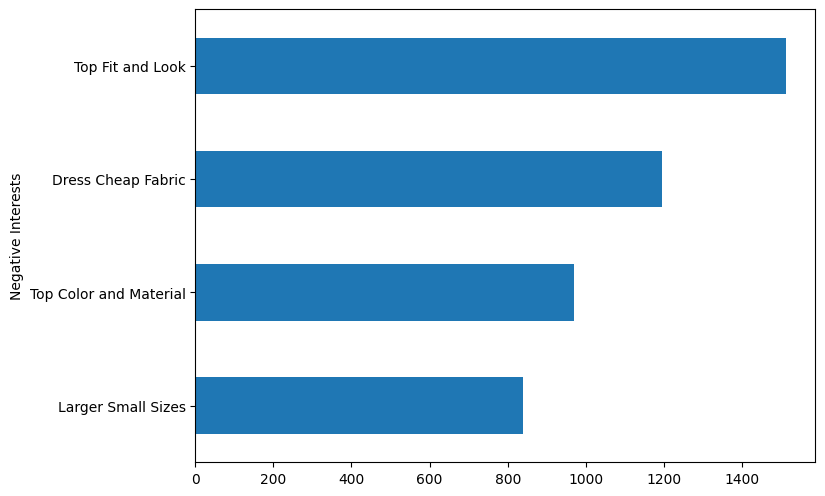

In [287]:
plt.figure(figsize=(8,6), dpi=100)
negative.topic.value_counts().plot.barh().invert_yaxis()
plt.ylabel('Negative Interests')
plt.savefig('pics/womens_negative_interest', bbox_inches='tight', dpi=450)

In [238]:
sample =  negative.sample(2)
for topic, text in zip(sample['topic'], sample['Review Text']):
    print(topic, end='\n\n')
    print(text, end='\n\n')
    print("="*50)

Top Color and Material

This is a very pretty sweater, a bit boxy and short but cute. i am 5'1" and ordered the regular xs in black. the thing i did not like about this sweater was the gold thread through the back lace. i would have kept this if it was plain black lace. just did not like that look.

Top Fit and Look

This sweater is beautiful and well made, but i found the cut strange and unflattering. i ordered it in my usual size small, and it was too big in the shoulders and arms, with a lot of fabric bunching up under my arms. but it just fit me in the chest, and would be too tight if i sized down. this might work for you if you are not busty and order a size down from your usual.

